### **GDAL/OGR Python API**

In [2]:
#Зададим рабочуют дирректорию
workdir = r"D:\MyProect\Lider_digital"
import os
# os.mkdir(workdir + r".\Lansat-8_2021_05_16")

In [3]:
# Импорт библиотек
from osgeo import gdal
from osgeo import ogr
# для работы с матрицей можно использовать библиотеку numpy
import numpy
# Визуализация растра библиотека matplotlib
import matplotlib.pyplot as plt

### Спектральные каналы спутника ДЗЗ «Landsat-8»
- Канал 1 (Coastal/Aerosol) – голубой и фиолетовый. Сильно рассеивается пылью и частицами атмосферы, используется для обнаружения дыма и тумана. Обеспечивает оценку «здоровья» биосферы океана по степени яркости.
- Каналы 2, 3, 4 (Blue, Green, Red) – видимые цвета спектра.
- Канал 5 (Near Infrared, NIR) – невидимый ближний ИК канал. Обеспечивает оценку состояния растительности суши по степени яркости, что обусловлено сильным отражением здоровой растительности.
- Каналы 6, 7 (Shortwave Infrared, SWIR-1/2) – инфракрасные каналы. Излучение сильно поглощается водой. Данные используются для различения видов растительности и почвы, облаков, снега и льда. 
- Канал 8 (Panchromatic) обеспечивает максимальное пространственное разрешение 15 м/пиксел.
- Канал 9 (Cirrus) обеспечивает различимость перистых и кучевых облаков.
- Каналы 10, 11 (Thermal Infrared, TIR-1/2) – каналы дальнего ИК (теплового) диапазона, дающие информацию о температуре поверхности Земли.

### Создание растра из отдельных каналов Landsat8
У нас есть несколько снимков Landsat-8 в каналах 2, 3, 4 соответствующих отраженному сигналу в синем, зеленом и красном видимых диапазонах длин волн соответственно. Сделать композит в естественных цветах.

In [4]:
# Исходные растры
b2_ds = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B2.TIF")
b3_ds = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B3.TIF")
b4_ds = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B4.TIF")

In [5]:
# Извлекаем каналы растра
# Читаем значения ячеек в канале как массив
b_data = b2_ds.GetRasterBand(1).ReadAsArray()
# Посмотрим на матрицу. Срез c 500 по 1500 строку, с 500 по 505 столбец
b_data[3500:4500, 1500:2505]
# Визуализируем отдельный канал
# plt.close()
# plt.imshow(b_data)
# plt.close()

array([[7144, 7116, 7098, ..., 7297, 7334, 7321],
       [7119, 7143, 7126, ..., 7278, 7309, 7317],
       [7124, 7219, 7172, ..., 7247, 7275, 7288],
       ...,
       [7430, 7390, 7374, ..., 6988, 7026, 7025],
       [7427, 7402, 7362, ..., 7007, 7023, 7038],
       [7399, 7396, 7372, ..., 7091, 7057, 7058]], dtype=uint16)

In [6]:
# Создаем новый датасет

# 1. Создаем драйвер
driver = gdal.GetDriverByName('GTiff')

# 2. Создаем набор данных Composit_rgb.TIF, копируя основные метаданные из любого одиночного канала
new_dataset = driver.Create(workdir + r".\Lansat-8_2021_05_16\Composit_rgb.TIF", b2_ds.RasterXSize, b2_ds.RasterYSize, 3, b2_ds.GetRasterBand(1).DataType)

# 3. Также берем из исходника информацию о СК и привязке
new_dataset.SetProjection(b2_ds.GetProjection())
new_dataset.SetGeoTransform(b2_ds.GetGeoTransform())

# ИЛИ Установим свою трансформацию
#new_dataset.SetGeoTransform((452845.0, 60.0, 0.0, -1999245.0, 0.0, -60.0))

# 4. Также берем из исходников массивы данных
new_dataset.GetRasterBand(1).WriteArray(b2_ds.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(2).WriteArray(b3_ds.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(3).WriteArray(b4_ds.GetRasterBand(1).ReadAsArray())

# 5. удаляя созданную переменную мы заставляем GDAL записать датасет в файл Composit_rgb.TIF на диск
# Чистим оперативную память
del new_dataset
# ПРОСМОТР ЧЕРЕЗ ArcGis или QGIS

#### Визуализируем полученный композит в блокноте Юпитера

In [7]:
comp = gdal.Open(workdir + r".\Lansat-8_2021_05_16\Composit_rgb.TIF")

comp_red_band_array = comp.GetRasterBand(1).ReadAsArray()
comp_green_band_array = comp.GetRasterBand(2).ReadAsArray()
comp_blue_band_array = comp.GetRasterBand(3).ReadAsArray()
# Собираем RGB матрицу
comp_rgb = numpy.dstack([comp_red_band_array, comp_green_band_array, comp_blue_band_array])
# Смотрим число ячеек и каналов
print(comp_rgb.shape)
print('Перед визуализацией растр нужно нормализовать:')
# Чистим оперативную память
del comp_rgb

(8021, 7931, 3)
Перед визуализацией растр нужно нормализовать:


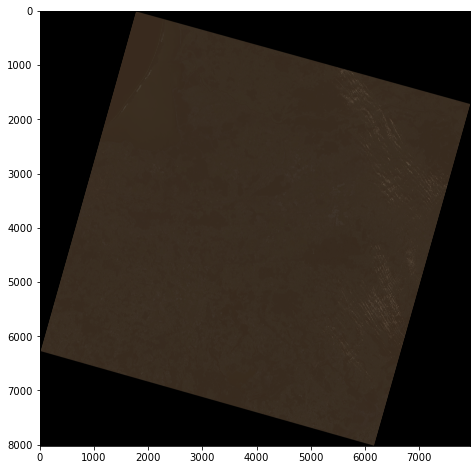

In [8]:
# Если ошибка Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
# Валидные входные данные функции imshow для RGB-схемы должны быть плавающими от 0 до 1 или целыми от о до 255
# Такие данные визуализировать не выходит потому что растр 16-битный, поэтому их надо предварительно нормализовать или преобразовать растр в 8-битный

def normalize(input_band):
    min_value, max_value = input_band.min()*1.0, input_band.max()*1.0
    return ((input_band*1.0 - min_value*1.0)/(max_value*1.0 - min_value*1.0))

# вызываем функцию для всех трех каналов
comp = gdal.Open(workdir + r".\Lansat-8_2021_05_16\Composit_rgb.TIF")

comp_red_band_array = comp.GetRasterBand(1).ReadAsArray()
comp_green_band_array = comp.GetRasterBand(2).ReadAsArray()
comp_blue_band_array = comp.GetRasterBand(3).ReadAsArray()

comp_red_band_array_norm = normalize(comp_red_band_array)
comp_green_band_array_norm = normalize(comp_green_band_array)
comp_blue_band_array_norm = normalize(comp_blue_band_array)

comp_rgb_norm = numpy.dstack([comp_red_band_array_norm, comp_green_band_array_norm, comp_blue_band_array_norm])

plt.rcParams['figure.figsize'] = (8, 8) # размер экстента
plt.close()
plt.imshow(comp_rgb_norm)
# plt.close()

### Растровая арифметика

In [9]:
# Создадим 7-канальный композит
# Исходные растры
b1_ds = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B1.TIF")
b2_ds = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B2.TIF")
b3_ds = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B3.TIF")
b4_ds = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B4.TIF")
b5_ds = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B5.TIF")
b6_ds = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B6.TIF")
b7_ds = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B7.TIF")

# Создаем новый датасет

# 1. Создаем драйвер
driver = gdal.GetDriverByName('GTiff')

# 2. Создаем набор данных Composit_rgb.TIF, копируя основные метаданные из любого одиночного канала
new_dataset = driver.Create(workdir + r".\Lansat-8_2021_05_16\Composit_bands_1_7.TIF", b1_ds.RasterXSize, b1_ds.RasterYSize, 7, b1_ds.GetRasterBand(1).DataType)

# 3. Также берем из исходника информацию о СК и привязке
new_dataset.SetProjection(b1_ds.GetProjection())
new_dataset.SetGeoTransform(b1_ds.GetGeoTransform())

# 4. Также берем из исходников массивы данных
new_dataset.GetRasterBand(1).WriteArray(b1_ds.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(2).WriteArray(b2_ds.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(3).WriteArray(b3_ds.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(4).WriteArray(b4_ds.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(5).WriteArray(b5_ds.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(6).WriteArray(b6_ds.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(7).WriteArray(b7_ds.GetRasterBand(1).ReadAsArray())

# 5. удаляя созданную переменную мы заставляем GDAL записать датасет в файл Composit_rgb.TIF на диск
# Чистим оперативную память
del new_dataset
# ПРОСМОТР ЧЕРЕЗ ArcGis (запусти gdal.mxd) или QGIS (запусти gdal.qgz)


In [10]:
# Берем два канала - видимый красный и ближний ИК измногоканального растра Composit_bands_1_7.tif
# Этот растр необходимо получить с применеием инструментария ArcGIS (н-р, Анализ изображений), QGIS, или библиотеки gdal (как показанно выше)

landsat_ds = gdal.Open(workdir + r".\Lansat-8_2021_05_16\Composit_bands_1_7.tif")
# Извлешем из многоканального растра видимый красный и ближний ИК каналы
red_band_array = landsat_ds.GetRasterBand(4).ReadAsArray()
nir_band_array = landsat_ds.GetRasterBand(5).ReadAsArray()

### Рассчет спектральных индексов (позволяют дать количественную оценку явлениям - можно использовать при рассчете антропогенной нагрузки)

#### **Нормализованный разностный индекс растительности (NDVI)** 
Это стандартизированный индекс, показывающий наличие и состояние растительности (относительную биомассу). Оценку необходимо производить в вегетационный период. Вытоптанные тропы и места должны иметь меньший коэффициент (так как растительность нездоровая и сухая), что апосредованно будет говорить о повышенной антропогенной нагрузке. 

In [11]:
# Расчет индекса растительности NDVI
ndvi_array = (nir_band_array - red_band_array) / 0.1 + (nir_band_array + red_band_array) # ошибка связана с делением на ноль в пространственно совпадающих ячейках матрицы
# Нормируем к единице
ndvi_array_norm = ndvi_array / numpy.nanmax(ndvi_array)

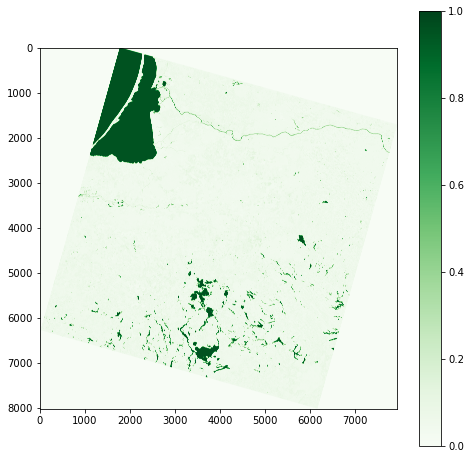

In [12]:
plt.close()
plt.imshow(ndvi_array_norm, cmap='Greens')
plt.colorbar()
plt.show()
# plt.close()

In [13]:
# Создаем масоку по пороговым значениям
ndvi_array_norm[ndvi_array_norm >= 0.4] = 1
ndvi_array_norm[ndvi_array_norm < 0.4] = 0

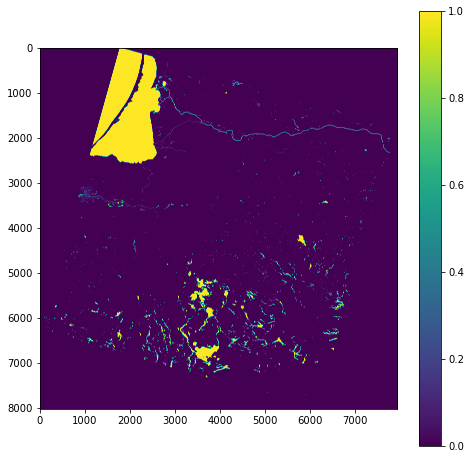

In [14]:
plt.close()
plt.imshow(ndvi_array_norm)
plt.colorbar()
plt.show()
# plt.close()

### Комбинирование растровых каналов

#### Синтез каналов 5-4-3 (NIR, Red, Green), «ложные», или «красные» цвета. 
Применяется для изучения состояния растительного покрова, мониторинга дренажа и почвенной мозаики, изучения сельскохозяйственных культур. Насыщенные оттенки красного являются индикаторами здоровой и (или) широколиственной растительности, в то время как более светлые оттенки характеризуют травянистую растительность или редколесья/кустарники. Растительность в этой комбинации имеет оттенки красного, городская застройка – зелено-голубые цвета, почва – от темно до светло коричневого или серого, лед, снег и облака – белые или светло голубые. Хвойные леса по сравнению с лиственными имеют более темно-красную или даже коричневую окраску. **Проверьте на ТБО, как вариант могут также светиться голубым**

In [16]:
# Исходные растры
nir_band_array = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B5.TIF")
red_band_arra = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B4.TIF")
green_band_array = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B3.TIF")

# Создаем новый датасет

# 1. Создаем драйвер
driver = gdal.GetDriverByName('GTiff')

# 2. Создаем набор данных, копируя основные метаданные из любого одиночного канала
new_dataset = driver.Create(workdir + r".\Lansat-8_2021_05_16\Composit_5_4_3.tif", nir_band_array.RasterXSize, nir_band_array.RasterYSize, 3, nir_band_array.GetRasterBand(1).DataType)

# 3. Также берем из исходника информацию о СК и привязке
new_dataset.SetProjection(nir_band_array.GetProjection())
new_dataset.SetGeoTransform(nir_band_array.GetGeoTransform())

# 4. Также берем из исходников массивы данных
new_dataset.GetRasterBand(1).WriteArray(nir_band_array.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(2).WriteArray(red_band_arra.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(3).WriteArray(green_band_array.GetRasterBand(1).ReadAsArray())

# 5. удаляя созданную переменную мы заставляем GDAL записать датасет в файл Composit_rgb.TIF на диск
# Чистим оперативную память
del new_dataset
# ПРОСМОТР ЧЕРЕЗ ArcGis или QGIS

####  Синтез каналов 5-4-2 (NIR, Red, Blue). Землепользование. 
Данная комбинация создает различие между городскими территориями, растительностью и водой. Показывает больший контраст на урбанизированных территориях.

In [17]:
# Исходные растры
nir_band_array = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B5.TIF")
red_band_arra = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B4.TIF")
blue_band_array = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B2.TIF")

# Создаем новый датасет

# 1. Создаем драйвер
driver = gdal.GetDriverByName('GTiff')

# 2. Создаем набор данных, копируя основные метаданные из любого одиночного канала
new_dataset = driver.Create(workdir + r".\Lansat-8_2021_05_16\Composit_5_4_2.tif", nir_band_array.RasterXSize, nir_band_array.RasterYSize, 3, nir_band_array.GetRasterBand(1).DataType)

# 3. Также берем из исходника информацию о СК и привязке
new_dataset.SetProjection(nir_band_array.GetProjection())
new_dataset.SetGeoTransform(nir_band_array.GetGeoTransform())

# 4. Также берем из исходников массивы данных
new_dataset.GetRasterBand(1).WriteArray(nir_band_array.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(2).WriteArray(red_band_arra.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(3).WriteArray(blue_band_array.GetRasterBand(1).ReadAsArray())

# 5. удаляя созданную переменную мы заставляем GDAL записать датасет в файл Composit_rgb.TIF на диск
# Чистим оперативную память
del new_dataset
# ПРОСМОТР ЧЕРЕЗ ArcGis или QGIS

#### Синтез каналов 7-5-3 (SWIR, NIR, Green). 
Данная комбинация весьма полезна при анализе пустынь, может быть использована для изучения сельскохозяйственных земель и водно-болотных угодий. **Пройденные пожарами территории выглядят ярко красными.** Городская застройка отображается в оттенках розово-фиолетового. Здоровая растительность выглядит ярко зеленой, травянистые сообщества – зелеными, ярко розовые участки детектируют открытую почву, коричневые и оранжевые тона характерны для разреженной растительности. Сухостойная растительность выглядит оранжевой, вода – голубой, фиолетовой. Песок, открытая почва и минералы могут быть представлены большим числом цветов и оттенков.

In [18]:
# Исходные растры
swir_band_array = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B7.TIF")
nir_band_arra = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B5.TIF")
green_band_array = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B3.TIF")

# Создаем новый датасет

# 1. Создаем драйвер
driver = gdal.GetDriverByName('GTiff')

# 2. Создаем набор данных, копируя основные метаданные из любого одиночного канала
new_dataset = driver.Create(workdir + r".\Lansat-8_2021_05_16\Composit_7_5_3.tif", swir_band_array.RasterXSize, swir_band_array.RasterYSize, 3, swir_band_array.GetRasterBand(1).DataType)

# 3. Также берем из исходника информацию о СК и привязке
new_dataset.SetProjection(swir_band_array.GetProjection())
new_dataset.SetGeoTransform(swir_band_array.GetGeoTransform())

# 4. Также берем из исходников массивы данных
new_dataset.GetRasterBand(1).WriteArray(swir_band_array.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(2).WriteArray(nir_band_arra.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(3).WriteArray(green_band_array.GetRasterBand(1).ReadAsArray())

# 5. удаляя созданную переменную мы заставляем GDAL записать датасет в файл Composit_rgb.TIF на диск
# Чистим оперативную память
del new_dataset
# ПРОСМОТР ЧЕРЕЗ ArcGis или QGIS

#### Синтез каналов 5-6-2 (NIR, SWIR, Blue). 
Добавление SWIR канала обеспечивает различимость возраста растительности. Здоровая растительность отображается в оттенках красного, коричневого, оранжевого и зеленого. Почвы могут выглядеть зелеными или коричневыми, урбанизированные территории – белесыми, серыми и зелено-голубыми, ярко голубой цвет может детектировать **недавно вырубленные территории**, а красноватые – восстановление растительности или разреженную растительность. Чистая, глубокая вода будет выглядеть темно синей (почти черной), для мелководья или высокого содержания взвесей в цвете преобладают более светлые синие оттенки.

In [22]:
# Исходные растры
nir_band_array = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B5.TIF")
swir_band_array = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B6.TIF")
blue_band_array = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B2.TIF")

# Создаем новый датасет

# 1. Создаем драйвер
driver = gdal.GetDriverByName('GTiff')

# 2. Создаем набор данных, копируя основные метаданные из любого одиночного канала
new_dataset = driver.Create(workdir + r".\Lansat-8_2021_05_16\Composit_5_6_2.tif", nir_band_array.RasterXSize, nir_band_array.RasterYSize, 3, nir_band_array.GetRasterBand(1).DataType)

# 3. Также берем из исходника информацию о СК и привязке
new_dataset.SetProjection(nir_band_array.GetProjection())
new_dataset.SetGeoTransform(nir_band_array.GetGeoTransform())

# 4. Также берем из исходников массивы данных
new_dataset.GetRasterBand(1).WriteArray(nir_band_array.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(2).WriteArray(swir_band_array.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(3).WriteArray(blue_band_array.GetRasterBand(1).ReadAsArray())

# 5. удаляя созданную переменную мы заставляем GDAL записать датасет в файл Composit_rgb.TIF на диск
# Чистим оперативную память
del new_dataset
# ПРОСМОТР ЧЕРЕЗ ArcGis или QGIS

#### Синтез каналов 7-6-4 (SWIR-2, SWIR-1, Red). 
Применяется **для мониторинга пожаров, так как тепловые аномалии выглядят красноватыми или желтыми. Также хорошо выделяются затопленные территории.** Они имеют темно-синий и почти черный цвет. Поглощение излучения в среднем ИК диапазоне водой позволяет четко выделять береговую линию и водные объекты на снимке. Растительность отображается в оттенках темно и светло зеленого, урбанизированные территории выглядят белыми, зелено-голубыми и малиновыми, почвы, песок и минералы могут иметь много разных цветов.

In [23]:
# Исходные растры
swir_2_band_array = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B7.TIF")
swir_1_band_array = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B6.TIF")
red_band_array = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B4.TIF")

# Создаем новый датасет

# 1. Создаем драйвер
driver = gdal.GetDriverByName('GTiff')

# 2. Создаем набор данных, копируя основные метаданные из любого одиночного канала
new_dataset = driver.Create(workdir + r".\Lansat-8_2021_05_16\Composit_7_6_4.tif", swir_2_band_array.RasterXSize, swir_2_band_array.RasterYSize, 3, swir_2_band_array.GetRasterBand(1).DataType)

# 3. Также берем из исходника информацию о СК и привязке
new_dataset.SetProjection(swir_2_band_array.GetProjection())
new_dataset.SetGeoTransform(swir_2_band_array.GetGeoTransform())

# 4. Также берем из исходников массивы данных
new_dataset.GetRasterBand(1).WriteArray(swir_2_band_array.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(2).WriteArray(swir_1_band_array.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(3).WriteArray(red_band_array.GetRasterBand(1).ReadAsArray())

# 5. удаляя созданную переменную мы заставляем GDAL записать датасет в файл Composit_rgb.TIF на диск
# Чистим оперативную память
del new_dataset
# ПРОСМОТР ЧЕРЕЗ ArcGis или QGIS

#### Синтез каналов 6-5-4 (SWIR, NIR, Red). 
Удобен для изучения растительного покрова и широко используется **для анализа состояния лесных сообществ.** Комбинация дает очень много информации и цветовых контрастов. Здоровая растительность выглядит ярко зеленой, а почвы – розовато-лиловыми. В отличие от синтеза 7-4-2, включающего канал SWIR2 и позволяющего изучать геологические процессы, эта комбинация дает возможность лучше различать и анализировать сельскохозяйственные угодья.

In [24]:
# Исходные растры
swir_band_array = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B6.TIF")
nir_band_array = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B5.TIF")
red_band_array = gdal.Open(workdir + r".\Lansat-8_2021_05_16\LC08_L1TP_188022_20211101_20211109_01_T1_B4.TIF")

# Создаем новый датасет

# 1. Создаем драйвер
driver = gdal.GetDriverByName('GTiff')

# 2. Создаем набор данных, копируя основные метаданные из любого одиночного канала
new_dataset = driver.Create(workdir + r".\Lansat-8_2021_05_16\Composit_6_5_4.tif", swir_band_array.RasterXSize, swir_band_array.RasterYSize, 3, swir_band_array.GetRasterBand(1).DataType)

# 3. Также берем из исходника информацию о СК и привязке
new_dataset.SetProjection(swir_band_array.GetProjection())
new_dataset.SetGeoTransform(swir_band_array.GetGeoTransform())

# 4. Также берем из исходников массивы данных
new_dataset.GetRasterBand(1).WriteArray(swir_band_array.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(2).WriteArray(nir_band_array.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(3).WriteArray(red_band_array.GetRasterBand(1).ReadAsArray())

# 5. удаляя созданную переменную мы заставляем GDAL записать датасет в файл Composit_rgb.TIF на диск
# Чистим оперативную память
del new_dataset
# ПРОСМОТР ЧЕРЕЗ ArcGis или QGIS